In [1]:
#Importing all the neccesary libraries
import numpy as np 
import pandas as pd 
import csv

import os
print(os.listdir("input"))

import regex as re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer


# viz
import matplotlib.pyplot as plt
%matplotlib inline
import sys

# for clustering
from scipy.cluster.hierarchy import ward, dendrogram, fcluster, single, complete, average, weighted
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score

['.ipynb_checkpoints', '951967.zip', 'Bug report 10.csv', 'Bug report 100.csv', 'Bug report.csv', 'JIRA-ALL.csv', 'JIRA-BUG.csv', 'JIRA.csv', 'preprocessed_data.csv']


In [2]:
data=pd.read_csv('Input/JIRA-BUG.csv')
data = data.reset_index()
data.head()

,index,Summary,Bug Location,Issue key,Issue id,Issue Type,Status,Project key,Project name,Project type,...,Comment.64,Comment.65,Comment.66,Comment.67,Comment.68,Comment.69,Comment.70,Parent,Parent summary,Status Category
0,0,[Dev][Demo][Admin Portal][Edit Bundle items]: ...,Admin Portal,CORE-4396,57063,Bug,To Do,CORE,Justice - Core Team,software,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,To Do
1,1,[Dev][Admin Portal][Create New][Create From ex...,Admin Portal,CORE-4385,57039,Bug,In Progress,CORE,Justice - Core Team,software,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,In Progress
2,2,Duplicate items while using Search items by ke...,Automation Test,CORE-4377,57007,Bug,To Do,CORE,Justice - Core Team,software,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,To Do
3,3,[AP] Default language and default region of st...,Admin Portal,CORE-4366,56971,Bug,QA,CORE,Justice - Core Team,software,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,In Progress
4,4,[Unity][SDK] Single draft store makes subscrip...,SDK,CORE-4365,56960,Bug,To Do,CORE,Justice - Core Team,software,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,To Do


In [3]:
data.shape

(651, 220)

In [4]:
data.isnull().sum()

index                0
Summary              0
Bug Location         0
Issue key            0
Issue id             0
                  ... 
Comment.69         650
Comment.70         650
Parent             516
Parent summary     516
Status Category      0
Length: 220, dtype: int64

In [5]:
cols_of_interest=["Summary", "Status","Description","Priority", "Issue Type", "Bug Location"]
data=data[cols_of_interest]
print(data.shape)
data.head()

(651, 6)


,Summary,Status,Description,Priority,Issue Type,Bug Location
0,[Dev][Demo][Admin Portal][Edit Bundle items]: ...,To Do,This issue occurs on *Add new bundle items.*\n...,P1,Bug,Admin Portal
1,[Dev][Admin Portal][Create New][Create From ex...,In Progress,This issue occurs on Create new Role and Creat...,P1,Bug,Admin Portal
2,Duplicate items while using Search items by ke...,To Do,"While making script for cleanup, we found that...",P2,Bug,Automation Test
3,[AP] Default language and default region of st...,QA,When we open Stores menu and look at the store...,P1,Bug,Admin Portal
4,[Unity][SDK] Single draft store makes subscrip...,To Do,The restriction of single draft store makes su...,P1,Bug,SDK


In [6]:
data.isnull().sum()

Summary          0
Status           0
Description     59
Priority         0
Issue Type       0
Bug Location     0
dtype: int64

In [7]:
data.Description = data.Description.fillna("0")
data.isnull().sum()

Summary         0
Status          0
Description     0
Priority        0
Issue Type      0
Bug Location    0
dtype: int64

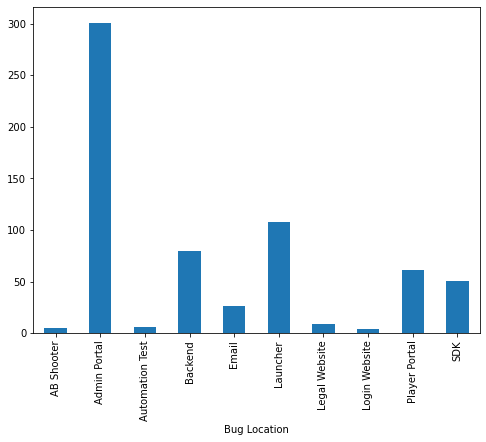

In [8]:
fig = plt.figure(figsize=(8,6))
data.groupby('Bug Location').Summary.count().plot.bar(ylim=0)
plt.show()

**Text data preprocessing steps**

1- Data Cleaning(either using regex or BeautifulSoup): 
a) Removing HTML characters. 
b) Removing punctuation. 
c) Decoding encoded data.
d) Split attached words.
e) Removing URLs. 
f) Apostrophe removal.
g) Removing Expressions. 
h) Uppercase & Lowercase letters 
i) Numbers such as amounts and data.

2- Data Tokenization(using word_tokenize in nltk.tokenize) 
Segregation of text into individual words i.e tokens.

3- Stopword Removal(using stopwords in nltk.corpus)
Discarding too common words or words which are not going to be helpful in our analysis.

4- Stemming(using WordNetLemmatizer in nltk.stem) 
Combining different variants of words into a single parent word that conveys same meaning.

In [9]:
stops = set(stopwords.words("english"))

In [10]:
dataConcat = pd.DataFrame()
dataConcat = data.Summary +" "+ data.Description+" "+data["Bug Location"]+" "+data.Status
dataConcat.to_csv("./Output/data_concat.csv")

In [11]:
dataConcat

0      [Dev][Demo][Admin Portal][Edit Bundle items]: ...
1      [Dev][Admin Portal][Create New][Create From ex...
2      Duplicate items while using Search items by ke...
3      [AP] Default language and default region of st...
4      [Unity][SDK] Single draft store makes subscrip...
                             ...                        
646    [STG][Launcher]Launcher didn't start automatic...
647    [STG][Launcher]Setting didn't revert to last s...
648    [STG][AP] Most of admin Portal features and co...
649    [STG][AP] There is no option to update client ...
650    [Backend]Can get the same user using different...
Length: 651, dtype: object

In [12]:
def clean_Description(content):
#     content = table.Description
    #Converting text to lowercase characters
    content = content.apply(lambda x: x.lower())
    #Removing HTML tags
    content = content.apply(lambda x: re.sub(r'\<[^<>]*\>','',x))
    #Removing any character which does not match to letter,digit or underscore
    content = content.apply(lambda x: re.sub(r'^\W+|\W+$',' ',x))
    #Removing space,newline,tab
    content = content.apply(lambda x: re.sub(r'\s',' ',x))
    #Removing punctuation
    content = content.apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))
    #Removing numeric
    content = content.apply(lambda x: re.sub(r'[0-9]','',x))
    #Tokenizing data
    content = content.apply(lambda x: word_tokenize(x))
    #Removing stopwords
    content = content.apply(lambda x: [i for i in x if i not in stops])
    type(content)
    return(content)

In [13]:
dataClean = clean_Description(dataConcat)

In [14]:
dataClean.head()

0    [dev, demo, portal, edit, bundle, items, add, ...
1    [dev, portal, create, new, create, existing, a...
2    [duplicate, items, using, search, items, keywo...
3    [ap, default, language, default, region, store...
4    [unity, sdk, single, draft, store, makes, subs...
dtype: object

## Stemming

In [15]:
dataClean.dtypes

dtype('O')

In [16]:
wordnet = WordNetLemmatizer()

In [17]:
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# factory = StemmerFactory()
# stemmer = WordNetLemmatizer()

In [18]:
steam = []
# dataFinal = np.array(dataFinal, dtype=str)
# # steam = steam.astype(str)
# for w in dataClean:
#     word = wordnet.lemmatize(w)
#     steam.append(word)
steam = dataClean.apply(lambda x:[wordnet.lemmatize(i,pos='v') for i in x])

In [19]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(list(set(data["Bug Location"])))
print(list(le.classes_))
num_labels = le.transform(data["Bug Location"]) 

['AB Shooter', 'Admin Portal', 'Automation Test', 'Backend', 'Email', 'Launcher', 'Legal Website', 'Login Website', 'Player Portal', 'SDK']


# Bag of Words

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
stopword_new = set([w for w in stops])
print ("Jumlah stop words:", len(stops))

Jumlah stop words: 361


In [22]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
dataFinal = []
for word in steam:
    words = TreebankWordDetokenizer().detokenize(word)
    dataFinal.append(words)

In [23]:
print(dataFinal[0])

dev demo portal edit bundle items add item type code season subscription return error response issue occur add new bundle items already create item bundle type draft store view bundle items please notice add item type code season subscription return error response note also please provide suitable error message one show fail update item try accountid please see attachment detail portal


In [24]:
count_vect = CountVectorizer(ngram_range=(1,1), stop_words=stops)
# steam = steam.astype(str)
bug_result = count_vect.fit_transform(dataFinal)

C:\Users\GF\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['false', 'true'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [25]:
# print(steam)

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(bug_result, num_labels, test_size=0.25, random_state=16)
print(X_train.shape)

(488, 2105)


In [27]:
print(y_test)

[1 1 3 1 1 9 1 1 5 5 1 3 1 1 3 1 9 1 1 1 5 3 1 1 9 9 5 5 5 3 8 1 1 1 5 3 1
 1 5 1 1 1 1 1 1 1 1 1 5 1 1 5 9 5 1 3 1 5 1 8 1 1 6 1 8 9 1 6 1 1 1 1 6 1
 3 5 3 1 6 9 3 1 9 1 4 1 8 4 1 1 1 2 8 5 5 3 1 3 9 5 1 1 1 1 1 3 1 3 5 1 8
 1 8 3 5 5 1 8 1 9 1 3 1 1 5 1 1 4 3 3 1 1 1 1 5 5 1 9 8 1 1 1 1 1 1 5 9 5
 1 8 1 8 5 1 3 3 1 3 9 5 5 1 5]


# Naive Bayes

In [28]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

clf1 = MultinomialNB().fit(X_train, y_train)
Predict = clf1.predict(X_test)

In [29]:
print ("Accuracy pada test data:", accuracy_score(Predict, y_test))
print ("Precision baseline pada test data:", precision_score(Predict, y_test, average='micro'))
print ("Recall baseline pada test data:", recall_score(Predict, y_test, average='micro'))
print ("F1 baseline pada test data:", f1_score(Predict, y_test, average='micro'))


Accuracy pada test data: 0.7055214723926381
Precision baseline pada test data: 0.7055214723926381
Recall baseline pada test data: 0.7055214723926381
F1 baseline pada test data: 0.7055214723926381


# Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
#Logistic Regression
clf1 = LogisticRegression().fit(X_train, y_train)
Predict1 = clf1.predict(X_test)

C:\Users\GF\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
print ("Accuracy pada test data:", accuracy_score(Predict1, y_test))
print ("Precision baseline pada test data:", precision_score(Predict1, y_test, average='micro'))
print ("Recall baseline pada test data:", recall_score(Predict1, y_test, average='micro'))
print ("F1 baseline pada test data:", f1_score(Predict1, y_test, average='micro'))

Accuracy pada test data: 0.8834355828220859
Precision baseline pada test data: 0.8834355828220859
Recall baseline pada test data: 0.8834355828220859
F1 baseline pada test data: 0.8834355828220859


# Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
#Random Forest
clf1 = RandomForestClassifier(max_depth=35, random_state=2)
clf1 = clf1.fit(X_train, y_train)
Predict1 = clf1.predict(X_test)

In [35]:
print ("Accuracy pada test data:", accuracy_score(Predict1, y_test))
print ("Precision baseline pada test data:", precision_score(Predict1, y_test, average='micro'))
print ("Recall baseline pada test data:", recall_score(Predict1, y_test, average='micro'))
print ("F1 baseline pada test data:", f1_score(Predict1, y_test, average='micro'))

Accuracy pada test data: 0.852760736196319
Precision baseline pada test data: 0.852760736196319
Recall baseline pada test data: 0.852760736196319
F1 baseline pada test data: 0.852760736196319


# Decision Tree

In [36]:
from sklearn import tree

clf1 = tree.DecisionTreeClassifier()
clf1 = clf1.fit(X_train, y_train)
Predict1 = clf1.predict(X_test)

In [37]:
print ("Accuracy pada test data:", accuracy_score(Predict1, y_test))
print ("Precision baseline pada test data:", precision_score(Predict1, y_test, average='micro'))
print ("Recall baseline pada test data:", recall_score(Predict1, y_test, average='micro'))
print ("F1 baseline pada test data:", f1_score(Predict1, y_test, average='micro'))

Accuracy pada test data: 0.9141104294478528
Precision baseline pada test data: 0.9141104294478528
Recall baseline pada test data: 0.9141104294478528
F1 baseline pada test data: 0.9141104294478528


# TF_IDF

# Naive Bayes

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer 

In [39]:
tfidf_vectorizer=TfidfVectorizer(ngram_range=(1,1), stop_words=stops)
 
tfidf_result=tfidf_vectorizer.fit_transform(dataFinal)

C:\Users\GF\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['false', 'true'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [40]:
x_train, x_test, Y_train, Y_test = train_test_split(tfidf_result, num_labels, test_size=0.25, random_state=28)
print(x_train.shape)

(488, 2105)


In [41]:
#Naive Bayes
clf1 = MultinomialNB().fit(x_train, Y_train)
Predict1 = clf1.predict(x_test)

In [42]:
print ("Accuracy pada test data:", accuracy_score(Predict1, Y_test))
print ("Precision baseline pada test data:", precision_score(Predict1, Y_test, average='micro'))
print ("Recall baseline pada test data:", recall_score(Predict1, Y_test, average='micro'))
print ("F1 baseline pada test data:", f1_score(Predict1, Y_test, average='micro'))

Accuracy pada test data: 0.5153374233128835
Precision baseline pada test data: 0.5153374233128835
Recall baseline pada test data: 0.5153374233128835
F1 baseline pada test data: 0.5153374233128835


# Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegression

In [44]:
#Logistic Regression
clf1 = LogisticRegression().fit(x_train, Y_train)
Predict1 = clf1.predict(x_test)

In [45]:
print ("Accuracy pada test data:", accuracy_score(Predict1, Y_test))
print ("Precision baseline pada test data:", precision_score(Predict1, Y_test, average='micro'))
print ("Recall baseline pada test data:", recall_score(Predict1, Y_test, average='micro'))
print ("F1 baseline pada test data:", f1_score(Predict1, Y_test, average='micro'))

Accuracy pada test data: 0.6993865030674846
Precision baseline pada test data: 0.6993865030674846
Recall baseline pada test data: 0.6993865030674846
F1 baseline pada test data: 0.6993865030674846


# Random Forest

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
#Random Forest
clf1 = RandomForestClassifier(max_depth=50, random_state=2)
clf1 = clf1.fit(x_train, Y_train)
Predict1 = clf1.predict(x_test)

In [48]:
print ("Accuracy pada test data:", accuracy_score(Predict1, Y_test))
print ("Precision baseline pada test data:", precision_score(Predict1, Y_test, average='micro'))
print ("Recall baseline pada test data:", recall_score(Predict1, Y_test, average='micro'))
print ("F1 baseline pada test data:", f1_score(Predict1, Y_test, average='micro'))

Accuracy pada test data: 0.9141104294478528
Precision baseline pada test data: 0.9141104294478528
Recall baseline pada test data: 0.9141104294478528
F1 baseline pada test data: 0.9141104294478528


# Decision Tree

In [49]:
from sklearn import tree

clf1 = tree.DecisionTreeClassifier()
clf1 = clf1.fit(x_train, Y_train)
Predict1 = clf1.predict(x_test)

In [50]:
# tree.plot_tree(clf)

In [51]:
print ("Accuracy pada test data:", accuracy_score(Predict1, Y_test))
print ("Precision baseline pada test data:", precision_score(Predict1, Y_test, average='micro'))
print ("Recall baseline pada test data:", recall_score(Predict1, Y_test, average='micro'))
print ("F1 baseline pada test data:", f1_score(Predict1, Y_test, average='micro'))

Accuracy pada test data: 0.9263803680981595
Precision baseline pada test data: 0.9263803680981595
Recall baseline pada test data: 0.9263803680981595
F1 baseline pada test data: 0.9263803680981595
